In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sondosya/son_dosya (1).xlsx
/kaggle/input/haftalk-tweet/weekly.xlsx


In [2]:
pip install tweepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 724.0 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tweepy

In [18]:
bearer_t = "*"
client = tweepy.Client(bearer_token=bearer_t)

In [19]:
query = "* -is:retweet"

In [20]:
start_time = '2022-10-20T00:00:00Z'
end_time = '2022-10-27T00:00:00Z'

In [27]:
tweets = tweepy.Paginator(client.search_recent_tweets, query=query,
                                    tweet_fields=['context_annotations', 'created_at','lang'], expansions = ["author_id"], max_results=100).flatten(limit=20000)

In [28]:
txt_lst = []
date_lst = []
for i in tweets:
    txt_lst.append(i.text)
    date_lst.append(i.created_at)

In [30]:
len(txt_lst)

8343

In [34]:
for i in range(len(date_lst)):
    date_lst[i] = date_lst[i].strftime('%Y-%m-%d')

In [35]:
date_lst[8000]

'2022-10-25'

In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sa= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

p = sa("bu telefon modelleri çok kaliteli , her parçası çok özel bence")
print(p)
# [{'label': 'LABEL_1', 'score': 0.9871089}]
print(p[0]['label'] == 'LABEL_1')
# True

p = sa("Film çok kötü ve çok sahteydi")
print(p)
# [{'label': 'LABEL_0', 'score': 0.9975505}]
print(p[0]['label'] == 'LABEL_1')
# False


Downloading:   0%|          | 0.00/596 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'positive', 'score': 0.983146607875824}]
False
[{'label': 'negative', 'score': 0.9990053772926331}]
False


In [37]:
com_lst = txt_lst

In [38]:
for i in range(len(com_lst)):
    com_lst[i] = com_lst[i].replace('\n','')
    new_text = ""
    for j in com_lst[i].split():
        if all(item not in j for item in ['@','#','https']):
            new_text = new_text + " " + ''.join(j)
    
    new_text = new_text.strip()
    com_lst[i] = new_text 

In [40]:
df = pd.DataFrame()

In [41]:
df['text'] = com_lst

In [42]:
df['date'] = date_lst

In [46]:
df = df.drop_duplicates(subset=['text'], keep='last')

In [47]:
df.reset_index(drop=True,inplace=True)

In [5]:
df['date'].value_counts()

2022-10-27    1561
2022-10-26    1241
2022-10-28     865
2022-10-31     504
2022-10-30     445
2022-10-29     316
2022-10-25     229
2022-11-01      11
Name: date, dtype: int64

In [17]:
df = pd.read_excel("../input/haftalk-tweet/weekly.xlsx")

In [18]:
df.isnull().sum()

Unnamed: 0    0
text          1
date          0
author_id     0
tweet_id      0
dtype: int64

In [19]:
df.dropna(axis=0,inplace=True)

In [20]:
df.isnull().sum()

Unnamed: 0    0
text          0
date          0
author_id     0
tweet_id      0
dtype: int64

In [21]:
label_lst = []
score_lst = []

for i in df['text']:
    deneme = sa(i)
    label_lst.append(deneme[0]['label'])
    if deneme[0]['label'] == "negative":
        score_lst.append(deneme[0]['score'] * -1)
    else:
        score_lst.append(deneme[0]['score'])

In [22]:
df['label'] = label_lst
df['score'] = score_lst

In [23]:
df['label'].value_counts()

negative    3548
positive    1623
Name: label, dtype: int64

In [25]:
import matplotlib.pyplot as plt

In [26]:
dates = np.array(df['date'])
indices = np.argsort(dates)

In [27]:
dates = df["date"].unique()


In [28]:
dates.sort()

In [30]:
dates = list(dates)

In [36]:
dates.pop(7)

'2022-11-01'

In [37]:
avg_scores = []
for i in dates:
    avg_score = df[df['date'] == i]['score'].sum() / df[df['date'] == i].shape[0]
    avg_scores.append(avg_score)

In [38]:
avg_scores

[-0.4901344151476065,
 -0.3778081343058617,
 -0.2921340896638825,
 -0.2558444107198991,
 -0.38424394647531873,
 -0.48281336594163704,
 -0.4827722527441524]

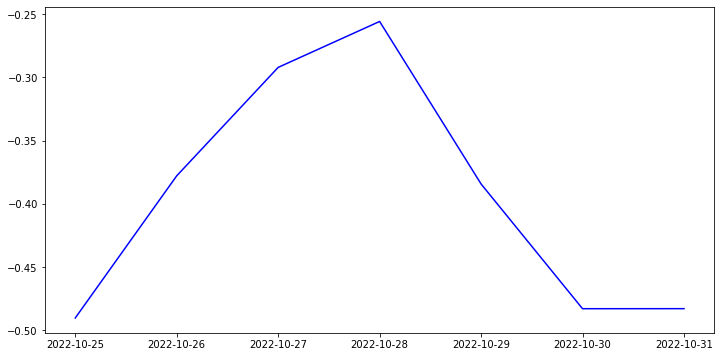

In [39]:
plt.figure(figsize=(12,6))
plt.plot(dates, avg_scores, color='blue', label='Average Sentiment')